In [2]:
import yfinance as yf
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import math
import joblib
import os
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error
from datetime import date
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import TensorDataset, DataLoader

In [3]:
symbol = 'META'
start_date = '2018-01-01'
end_date = date.today().strftime("%Y-%m-%d")

df = yf.download(symbol, start=start_date, end=end_date)
data = df['Close'].values.reshape(-1, 1)

[*********************100%***********************]  1 of 1 completed


In [4]:
df.head()

Price,Close,High,Low,Open,Volume
Ticker,META,META,META,META,META
Date,,,,,
2018-01-02,180.161530,180.320423,176.318380,176.447468,18151900
2018-01-03,183.388977,183.498215,180.072150,180.618337,16886600
2018-01-04,183.051346,184.918310,182.822946,183.617384,13880900
2018-01-05,185.553848,185.603489,183.647154,184.302579,13574500
2018-01-08,186.973907,187.589602,185.037438,185.901398,17994700


In [30]:
df['Close']

Ticker,META
Date,
2018-01-02,180.161514
2018-01-03,183.388962
2018-01-04,183.051315
2018-01-05,185.553848
2018-01-08,186.973907
...,...
2026-01-16,620.250000
2026-01-20,604.119995
2026-01-21,612.960022


In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2026 entries, 2018-01-02 to 2026-01-23
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   (Close, META)   2026 non-null   float64
 1   (High, META)    2026 non-null   float64
 2   (Low, META)     2026 non-null   float64
 3   (Open, META)    2026 non-null   float64
 4   (Volume, META)  2026 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 95.0 KB


In [32]:
device = ('cuda' if torch.cuda.is_available() else 'cpu')
print(f"=== Device used : {device} ===")

=== Device used : cpu ===


In [33]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

In [34]:
print(scaled_data[:5])

[[0.13114099]
 [0.13574814]
 [0.13526615]
 [0.13883849]
 [0.14086561]]


In [35]:
seq_length = 60
X = []
y = []

for i in range(seq_length, len(scaled_data)):
    X.append(scaled_data[i-seq_length:i])
    y.append(scaled_data[i])

X, y = np.array(X), np.array(y)

In [36]:
X.shape

(1966, 60, 1)

In [37]:
y.shape

(1966, 1)

In [38]:
train_size = int(len(X) * 0.8)

X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

#Convertendo para Tensores PyTorch
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

print(f'Treino: {X_train.shape}')
print(f'Teste: {X_test.shape}')

Treino: torch.Size([1572, 60, 1])
Teste: torch.Size([394, 60, 1])


In [39]:
class ModeloLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(ModeloLSTM, self). __init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :]) # Pega apenas o último passo temporal
        return out

In [40]:
# Configuração de Hiperparâmetros
input_size = 1        #Temos 1 feature (close price)
hidden_size = 60      #Memória do LSTM
output_size = 1       #Prever apenas o preço
learning_rate = 0.001

In [41]:
modelo = ModeloLSTM(input_size, hidden_size, output_size)

criterio = nn.MSELoss()
optimizer = torch.optim.Adam(modelo.parameters(), lr=learning_rate)
modelo

ModeloLSTM(
  (lstm): LSTM(1, 60, batch_first=True)
  (fc): Linear(in_features=60, out_features=1, bias=True)
)

In [42]:
dataset_treino = TensorDataset(X_train, y_train)
loader = DataLoader(dataset_treino, batch_size=32,shuffle=True)
num_epochs = 50 #Vezes que o modelo vê os dados

# O DataLoader fatia os dados em lotes de 32 (batch_size)
# shuffle=True aqui é BOM: ajuda o modelo a não decorar a ordem dos dias, 
# já que cada amostra X já contém a sequência de 60 dias internamente.


In [43]:
history = {
    'train_loss': [],
    'val_loss': []
}

modelo.train()

for epoch in range(num_epochs):
    train_losses = []
    for batch_X, batch_y in loader: # Loop interno percorrendo os pequenos lotes batch de X_train
        optimizer.zero_grad()       # Zera
        outputs = modelo(batch_X) # Preve
        loss = criterio(outputs, batch_y) # Calcula Erro
        loss.backward()             # Calcula Ajustes
        optimizer.step()           # Aplica
        train_losses.append(loss.item())
    
    # Cálculo da perda de validação (usando o conjunto de teste)
    modelo.eval()
    with torch.no_grad():
        val_outputs = modelo(X_test)
        val_loss = criterio(val_outputs, y_test)
    
    # Armazena as médias das perdas
    history['train_loss'].append(np.mean(train_losses))
    history['val_loss'].append(val_loss.item())
    
    modelo.train() # Volta para o modo de treino

     # Monitoramento (apenas para não poluir a tela, printamos a cada 10 épocas)    
    if (epoch+1) % 10 == 0:
        print(f'Época [{epoch+1}/{num_epochs}], Train Loss: {history["train_loss"][-1]:.6f}, Val Loss: {history["val_loss"][-1]:.6f}')

print("Treino com Mini-Batch concluído e perdas registradas!")

Época [10/50], Train Loss: 0.000258, Val Loss: 0.001836
Época [20/50], Train Loss: 0.000192, Val Loss: 0.000833
Época [30/50], Train Loss: 0.000173, Val Loss: 0.001292
Época [40/50], Train Loss: 0.000147, Val Loss: 0.000661
Época [50/50], Train Loss: 0.000131, Val Loss: 0.000524
Treino com Mini-Batch concluído e perdas registradas!


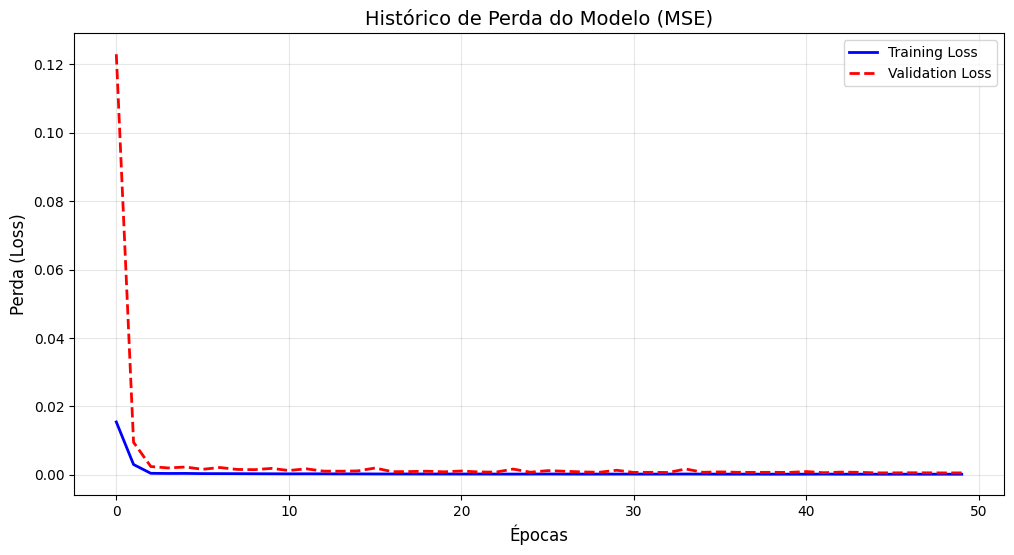

In [44]:
plt.figure(figsize=(12, 6))
plt.plot(history['train_loss'], label='Training Loss', color='blue', linewidth=2)
plt.plot(history['val_loss'], label='Validation Loss', color='red', linestyle='--', linewidth=2)

plt.title('Histórico de Perda do Modelo (MSE)', fontsize=14)
plt.xlabel('Épocas', fontsize=12)
plt.ylabel('Perda (Loss)', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [45]:
modelo.eval()

with torch.no_grad(): #previsões sem calcular gradientes (economiza memória)
    outputs = modelo(X_test)

outputs_np = outputs.cpu().numpy()
y_test_np = y_test.cpu().numpy()

#Inverter a Escala (Voltar de 0 e 1 para Dólares Reais)
outputs_real = scaler.inverse_transform(outputs_np)
y_test_real = scaler.inverse_transform(y_test_np)

In [46]:
mae = mean_absolute_error(y_test_real, outputs_real)
rmse = math.sqrt(mean_squared_error(y_test_real, outputs_real))

print(f"=== Resultados da Avaliação ===")
print(f"MAE (Erro Médio Absoluto): ${mae:.2f}")
print(f"RMSE (Raiz do Erro Quadrático Médio): ${rmse:.2f}")
print(f"O modelo erra, em média, cerca de ${mae:.2f} por ação.")

=== Resultados da Avaliação ===
MAE (Erro Médio Absoluto): $11.81
RMSE (Raiz do Erro Quadrático Médio): $16.04
O modelo erra, em média, cerca de $11.81 por ação.


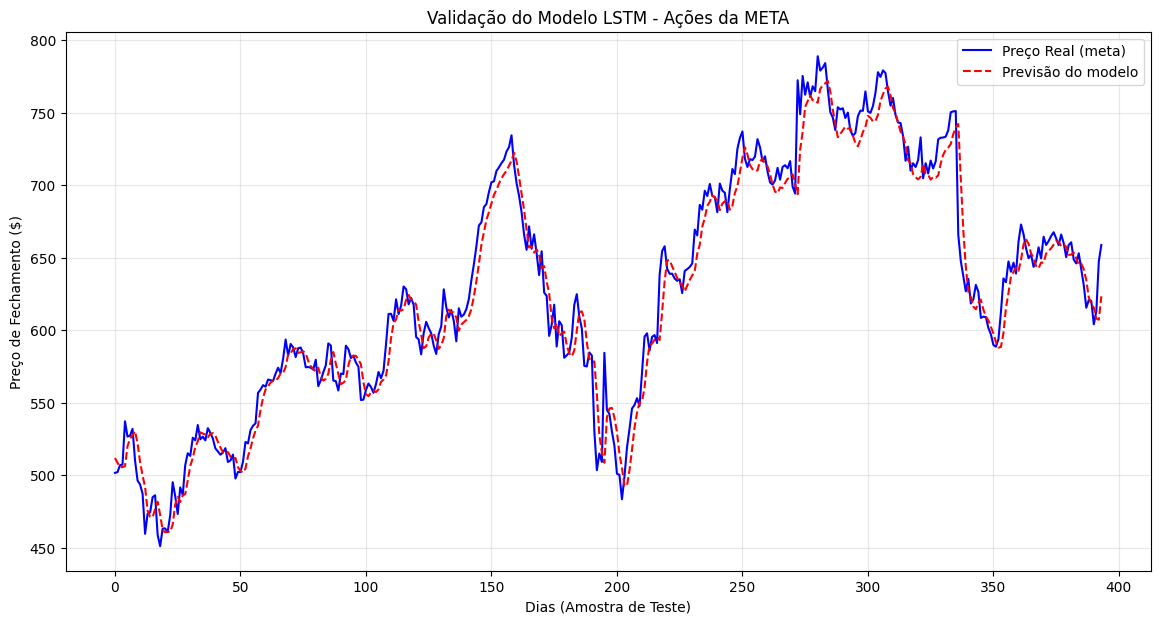

In [47]:
plt.figure(figsize=(14, 7))
plt.plot(y_test_real, label='Preço Real (meta)', color = 'blue', linewidth=1.5)
plt.plot(outputs_real, label='Previsão do modelo', color='red', linestyle='--', linewidth=1.5)

plt.title('Validação do Modelo LSTM - Ações da META')
plt.xlabel('Dias (Amostra de Teste)')
plt.ylabel('Preço de Fechamento ($)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

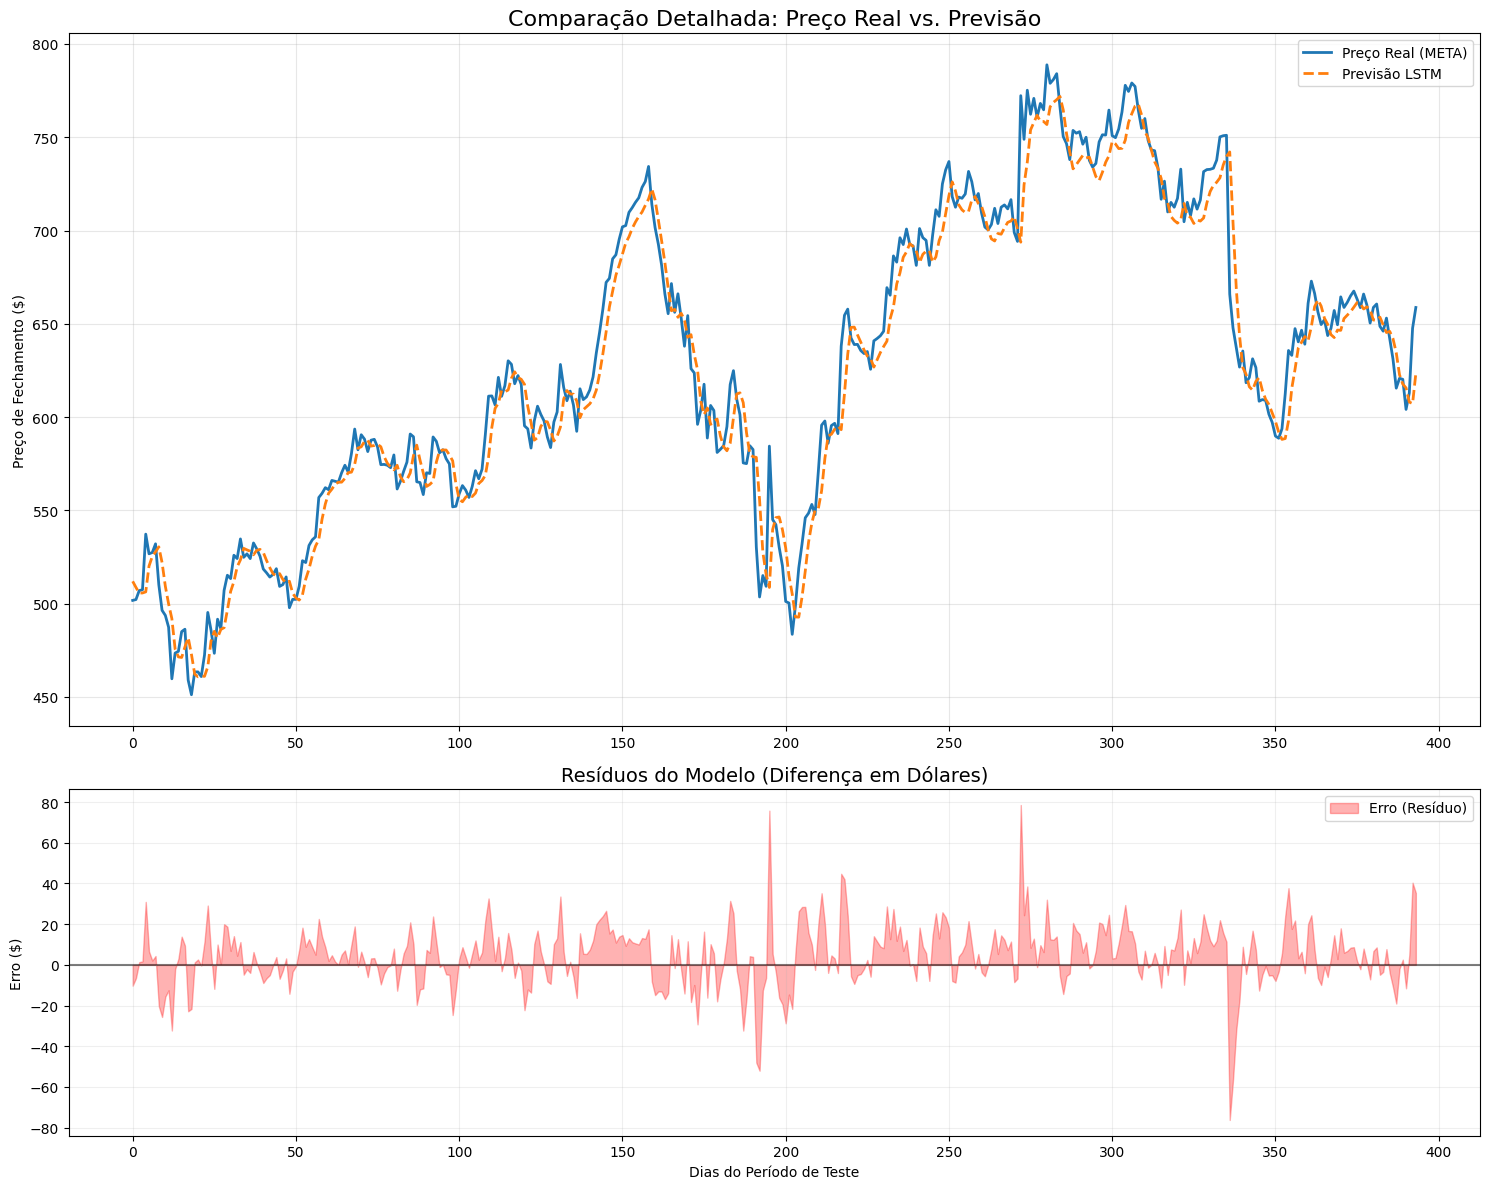

In [48]:
# --- Célula para Visualização de Resultados ---

erros = y_test_real - outputs_real

fig, ax = plt.subplots(2, 1, figsize=(15, 12), gridspec_kw={'height_ratios': [2, 1]})

# Gráfico 1: Real vs Previsto (Zoom no período de teste)
ax[0].plot(y_test_real, label='Preço Real (META)', color='#1f77b4', linewidth=2)
ax[0].plot(outputs_real, label='Previsão LSTM', color='#ff7f0e', linestyle='--', linewidth=2)
ax[0].set_title('Comparação Detalhada: Preço Real vs. Previsão', fontsize=16)
ax[0].set_ylabel('Preço de Fechamento ($)')
ax[0].legend()
ax[0].grid(True, alpha=0.3)

# Gráfico 2: Erro Residual (Diferença entre Real e Previsto)
ax[1].fill_between(range(len(erros)), erros.flatten(), color='red', alpha=0.3, label='Erro (Resíduo)')
ax[1].axhline(y=0, color='black', linestyle='-', alpha=0.5)
ax[1].set_title('Resíduos do Modelo (Diferença em Dólares)', fontsize=14)
ax[1].set_xlabel('Dias do Período de Teste')
ax[1].set_ylabel('Erro ($)')
ax[1].legend()
ax[1].grid(True, alpha=0.2)

plt.tight_layout()
plt.show()

C:\Users\igor_\AppData\Local\Temp\ipykernel_18796\519287500.py:1: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  df_anual = df['Close'].resample('Y').mean()
C:\Users\igor_\AppData\Local\Temp\ipykernel_18796\519287500.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_mensal = df['Close'].resample('M').mean()


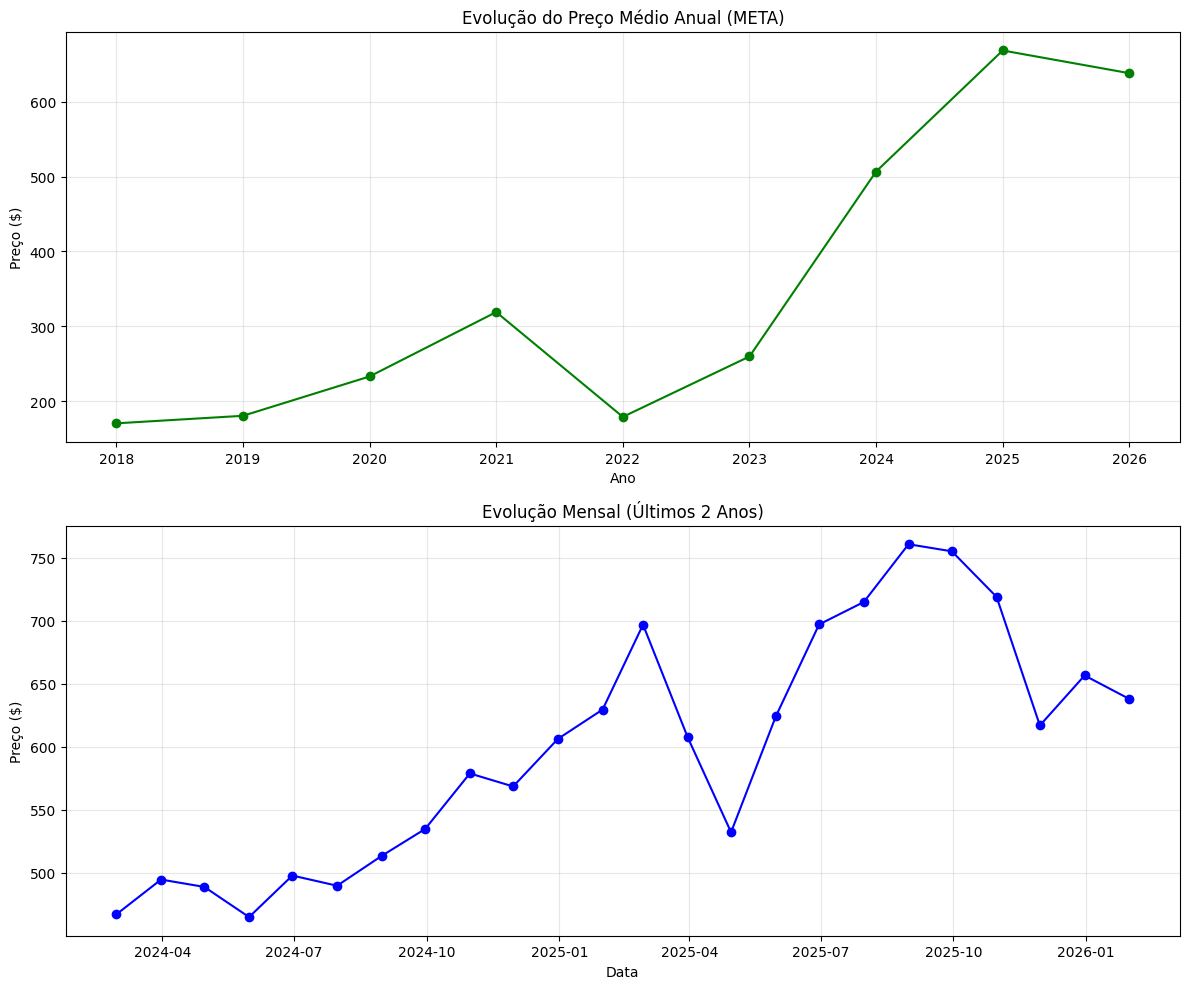

In [ ]:
df_anual = df['Close'].resample('Y').mean()
df_mensal = df['Close'].resample('M').mean()

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Gráfico Anual
ax1.plot(df_anual.index.year, df_anual.values, marker='o', linestyle='-', color='green')
ax1.set_title('Evolução do Preço Médio Anual (META)')
ax1.set_xlabel('Ano')
ax1.set_ylabel('Preço ($)')
ax1.grid(True, alpha=0.3)

# Gráfico Mensal (pegando apenas os últimos 24 meses para não poluir)
dados_recentes = df_mensal.iloc[-24:] 
ax2.plot(dados_recentes.index, dados_recentes.values, marker='o', color='blue')
ax2.set_title('Evolução Mensal (Últimos 2 Anos)')
ax2.set_xlabel('Data')
ax2.set_ylabel('Preço ($)')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [49]:
folder = 'environment' 

# Salva direto, sem frescura
torch.save(modelo.state_dict(), os.path.join(folder, 'modelo_lstm_meta.pth'))
joblib.dump(scaler, os.path.join(folder, 'scaler.pkl'))

print("Artefatos salvos com sucesso na pasta 'environment'.")

Artefatos salvos com sucesso na pasta 'environment'.
